# Set Environment & Globals

In [2]:
%load_ext jupyter_black

# base
import os
import sys
import warnings
import logging
from tqdm import tqdm

logging.basicConfig(level="INFO")
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

# data manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter("ignore", pd.errors.DtypeWarning)
mlogger = logging.getLogger("matplotlib")
mlogger.setLevel(logging.WARNING)

# single cell
import scanpy as sc
import spatialdata as sd

# custom
from spatial_seq.R import *
from spatial_seq.sc_preprocess import *
from spatial_seq.plot import *
from spatial_seq.sc_analysis import *

# R
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter

converter = get_converter()
%load_ext rpy2.ipython

/mnt/DATA/home/ethung/spatial_seq/.venv/lib/python3.12/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
  warnings.warn(deprecation_msg, DeprecationWarning)
/mnt/DATA/home/ethung/spatial_seq/.venv/lib/python3.12/site-packages/phenograph/cluster.py:13: DeprecationWarning: Please import `spmatrix` from the `scipy.sparse` namespace; the `scipy.sparse.base` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.sparse.base import spmatrix


In [1]:
# analysis & device specific
%matplotlib inline
CORES = 10
DATADIR = "../../data"
REFDIR = "../../references"

# Access SpatialData

### Import data

In [125]:
from spatialdata_io import visium_hd
import spatialdata_plot as sdp
from spatialdata import get_extent, bounding_box_query, rasterize_bins
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent


def GetSpatialData(
    directory: str,
    savedir: str,
    intermediate_path: str = "outs",
    exclude: List = None,
    overwrite=True,
    get_sdata=True,
    **kwargs,
):
    """
    Gets all spatial data from a directory.
    **kwargs are sent to `spatialdata_io.visium_hd()`
    """
    sdatas = {}
    barcodes = {}
    samples = os.listdir(directory)
    for s in exclude:
        samples.remove(s)

    for n, sample in tqdm(enumerate(samples)):
        print(sample)

        savefile = os.path.join(savedir, sample, "object.zarr")

        if get_sdata is True:
            if overwrite is True:
                sdata = visium_hd(
                    os.path.join(directory, sample, intermediate_path),
                    dataset_id=sample,
                    load_all_images=True,
                    var_names_make_unique=True,
                )
                sdata.write(savefile, overwrite=overwrite, **kwargs)

            sdata = sd.read_zarr(savefile)
            for table in sdata.tables.values():
                table.obs["Identifier"] = sample
                table.layers["counts"] = table.X

            sdatas[sample] = sdata

        spatial_barcode_subsets = os.listdir(os.path.join(savedir, sample))
        barcodes[sample] = {}
        for csv in spatial_barcode_subsets:
            if ".csv" in csv:
                barcodes[sample][csv] = pd.read_csv(os.path.join(savedir, sample, csv))

                if csv == "JB autocluster.csv":
                    newname = "Autocluster Labels"
                elif csv == "JB drawn.csv":
                    newname = "ROI Labels"
                elif csv == "EH whole tissue.csv":
                    newname = "Whole Tissue"
                else:
                    print(csv)

                colname = barcodes[sample][csv].columns[-1]
                barcodes[sample][csv].rename(columns={colname: newname}, inplace=True)
                barcodes[sample][csv].set_index("Barcode", inplace=True)

    return samples, sdatas, barcodes


samples, sdatas, barcodes = GetSpatialData(
    os.path.join(DATADIR, "spaceranger", "LM13969"),
    os.path.join(DATADIR, "processed", "raws"),
    exclude=["LFD-cKO-male-780-VAT-2"],
    overwrite=False,
    get_sdata=True,
)

sample = samples[0]
sdata = sdatas[sample]
sdata

0it [00:00, ?it/s]WARNING:ome_zarr.io:version mismatch: detected: RasterFormatV02, requested: FormatV04


LFD-CTR-male-670-VAT


1it [00:33, 33.41s/it]WARNING:ome_zarr.io:version mismatch: detected: RasterFormatV02, requested: FormatV04


HFD-cKO-male-666-VAT


2it [00:58, 28.32s/it]WARNING:ome_zarr.io:version mismatch: detected: RasterFormatV02, requested: FormatV04


LFD-cKO-male-780-VAT


3it [01:14, 24.79s/it]


SpatialData object, with associated Zarr store: /mnt/DATA/home/ethung/spatial_seq/data/processed/raws/LFD-CTR-male-670-VAT/object.zarr
├── Images
│     ├── 'LFD-CTR-male-670-VAT_cytassist_image': DataArray[cyx] (3, 3000, 3200)
│     ├── 'LFD-CTR-male-670-VAT_hires_image': DataArray[cyx] (3, 4960, 6000)
│     └── 'LFD-CTR-male-670-VAT_lowres_image': DataArray[cyx] (3, 496, 600)
├── Shapes
│     ├── 'LFD-CTR-male-670-VAT_square_002um': GeoDataFrame shape: (10554741, 1) (2D shapes)
│     ├── 'LFD-CTR-male-670-VAT_square_008um': GeoDataFrame shape: (667104, 1) (2D shapes)
│     └── 'LFD-CTR-male-670-VAT_square_016um': GeoDataFrame shape: (168829, 1) (2D shapes)
└── Tables
      ├── 'square_002um': AnnData (10554741, 19070)
      ├── 'square_008um': AnnData (667104, 19070)
      └── 'square_016um': AnnData (168829, 19070)
with coordinate systems:
    ▸ 'LFD-CTR-male-670-VAT', with elements:
        LFD-CTR-male-670-VAT_cytassist_image (Images), LFD-CTR-male-670-VAT_hires_image (Images), LFD

In [126]:
# sdata.pl.render_images().pl.show()

INFO     Rasterizing image for faster rendering.                                                                   


INFO     Rasterizing image for faster rendering.                                                                   


INFO     Rasterizing image for faster rendering.                                                                   


CPU times: user 11.8 s, sys: 2.32 s, total: 14.1 s
Wall time: 14.1 s


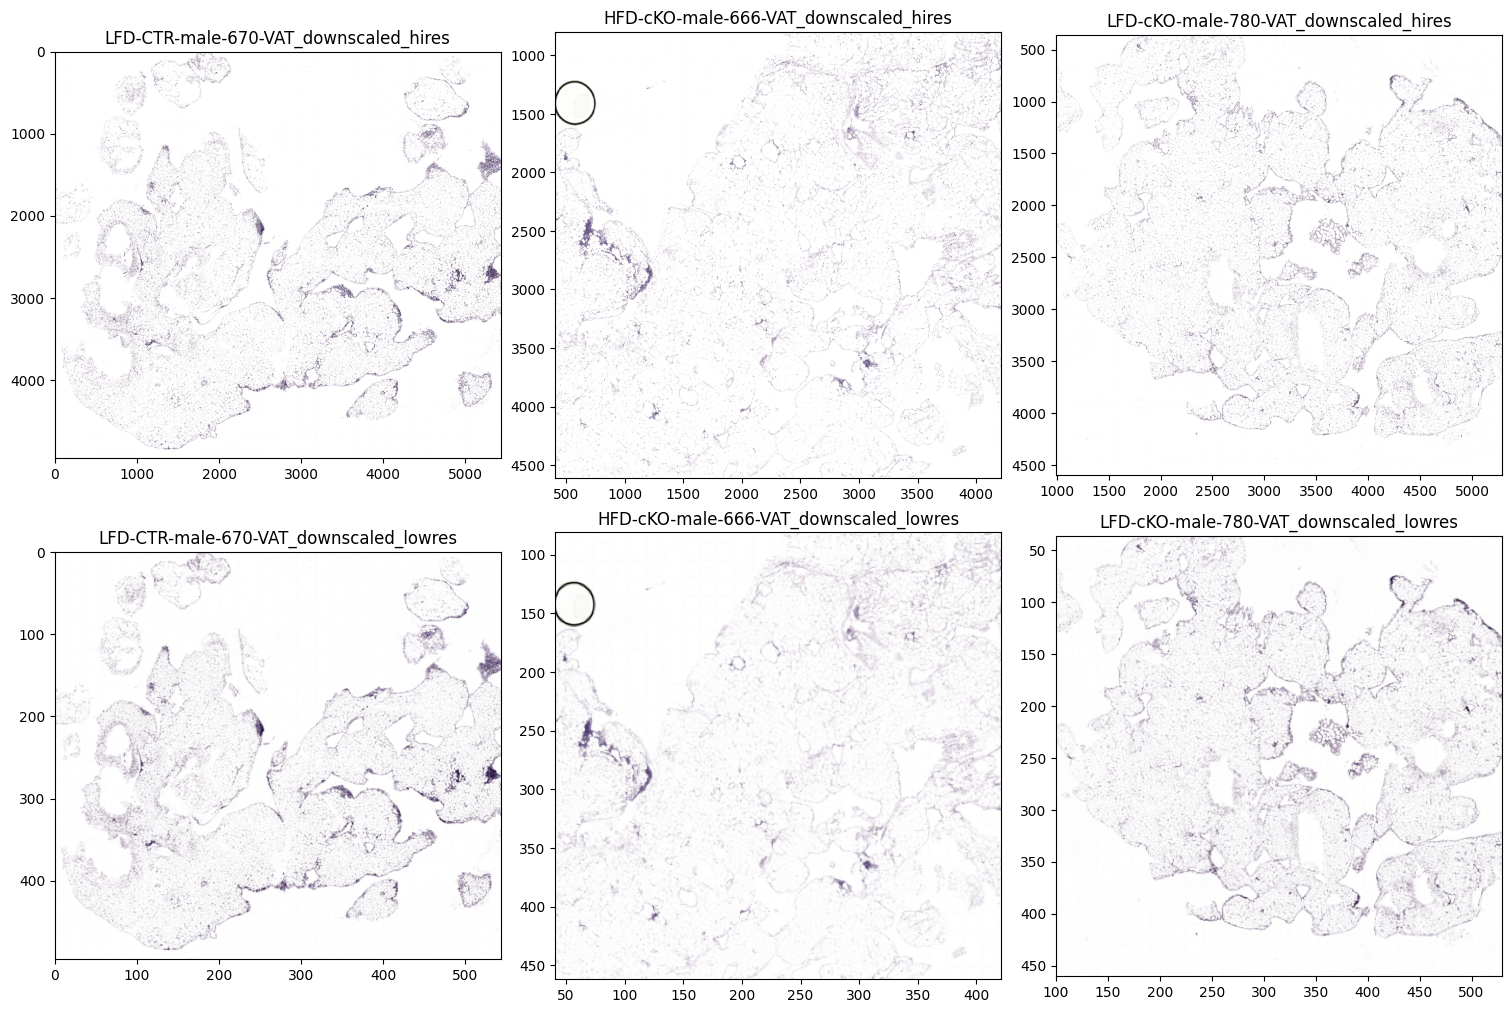

In [127]:
%%time
# get aligned hires

f, axs = plt.subplots(
    2, len(samples), figsize=(len(samples) * 5, 10), layout="constrained"
)
for i, samp in enumerate(samples):
    data_extent = {}

    mins = np.min(sdatas[samp].tables["square_016um"].obsm["spatial"], axis=0)
    maxs = np.max(sdatas[samp].tables["square_016um"].obsm["spatial"], axis=0)
    data_extent["x"] = (mins[0], maxs[0])
    data_extent["y"] = (mins[1], maxs[1])

    queried_img = bounding_box_query(
        sdatas[samp][f"{samples[i]}_hires_image"],
        min_coordinate=[data_extent["x"][0], data_extent["y"][0]],
        max_coordinate=[data_extent["x"][1], data_extent["y"][1]],
        axes=("x", "y"),
        target_coordinate_system=samp,
    )
    sdatas[samp]["queried_hires"] = queried_img
    sdatas[samp].pl.render_images("queried_hires").pl.show(
        coordinate_systems=f"{samp}_downscaled_hires", ax=axs[0][i]
    )

    queried_img = bounding_box_query(
        sdatas[samp][f"{samples[i]}_lowres_image"],
        min_coordinate=[data_extent["x"][0], data_extent["y"][0]],
        max_coordinate=[data_extent["x"][1], data_extent["y"][1]],
        axes=("x", "y"),
        target_coordinate_system=samp,
    )
    sdatas[samp]["queried_lowres"] = queried_img
    sdatas[samp].pl.render_images("queried_lowres").pl.show(
        coordinate_systems=f"{samp}_downscaled_lowres", ax=axs[1][i]
    )

In [128]:
for n, samp in enumerate(samples):
    for bin_size in ["016", "008", "002"]:
        sdatas[samp][f"square_{bin_size}um"].X = sdatas[samp][
            f"square_{bin_size}um"
        ].X.tocsc()
        rasterized = rasterize_bins(
            sdatas[samp],
            f"{samp}_square_{bin_size}um",
            f"square_{bin_size}um",
            "array_col",
            "array_row",
        )
        sdatas[samp][f"rasterized_008um"] = rasterized

### Sample Plot

In [ ]:
gene_name = "Adgre1"
trans_cmap = set_zero_in_cmap_to_transparent(cmap="Reds")

f, axs = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
sdata.pl.render_images(
    "rasterized_016um", channel=gene_name, scale="full", cmap=trans_cmap
).pl.show(
    coordinate_systems=sample,
    ax=axs[0],
)

sdata.pl.render_images(f"{sample}_lowres_image", scale="full").pl.show(
    coordinate_systems=sample,
    ax=axs[1],
)

In [ ]:
sdata_small = sdatas[sample].query.bounding_box(
    min_coordinate=[22000, 27000],
    max_coordinate=[25000, 35000],
    axes=("x", "y"),
    target_coordinate_system=sample,
)

gene_name = "Adgre1"
trans_cmap = set_zero_in_cmap_to_transparent(cmap="Reds")

f, axs = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
sdata_small.pl.render_images(
    "rasterized_016um", channel=gene_name, scale="full", cmap=trans_cmap
).pl.show(
    coordinate_systems=sample,
    ax=axs[0],
)

sdata_small.pl.render_images(f"{sample}_lowres_image", scale="full").pl.show(
    coordinate_systems=sample,
    ax=axs[1],
)

# Initial Clustering

### QC

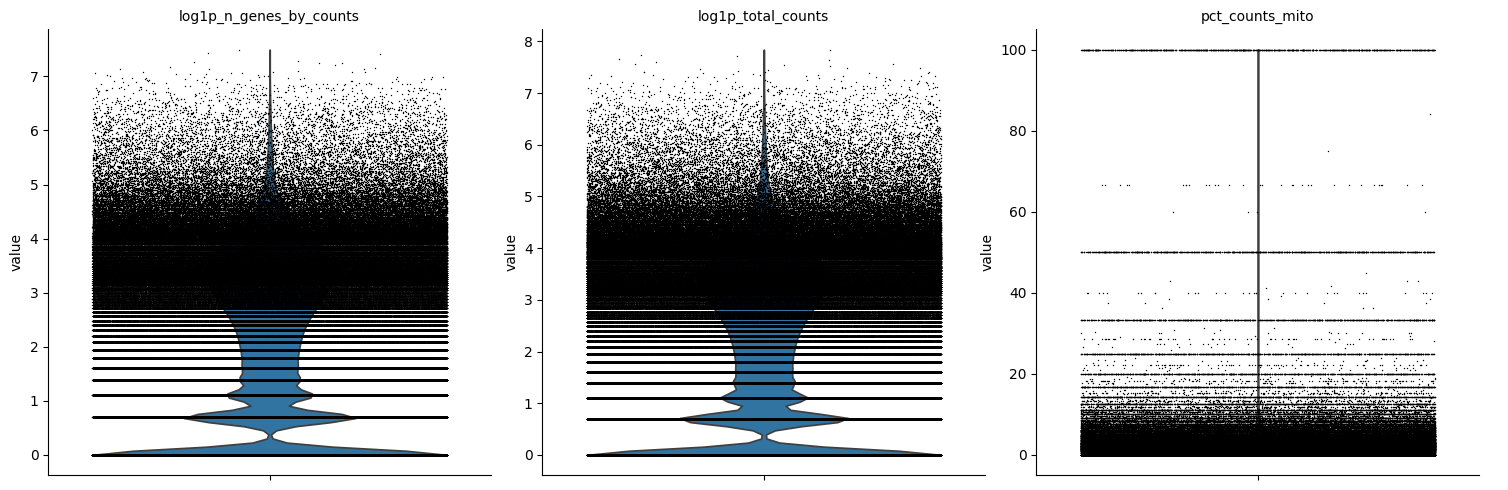

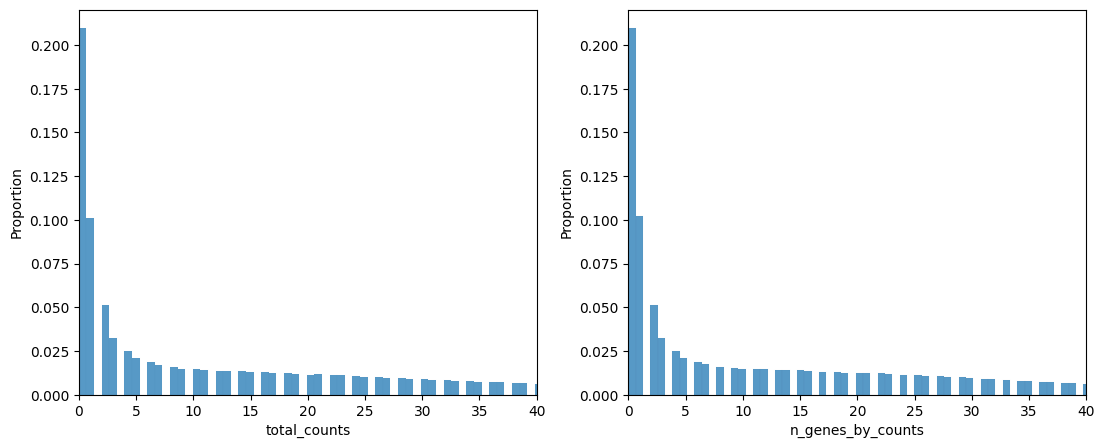

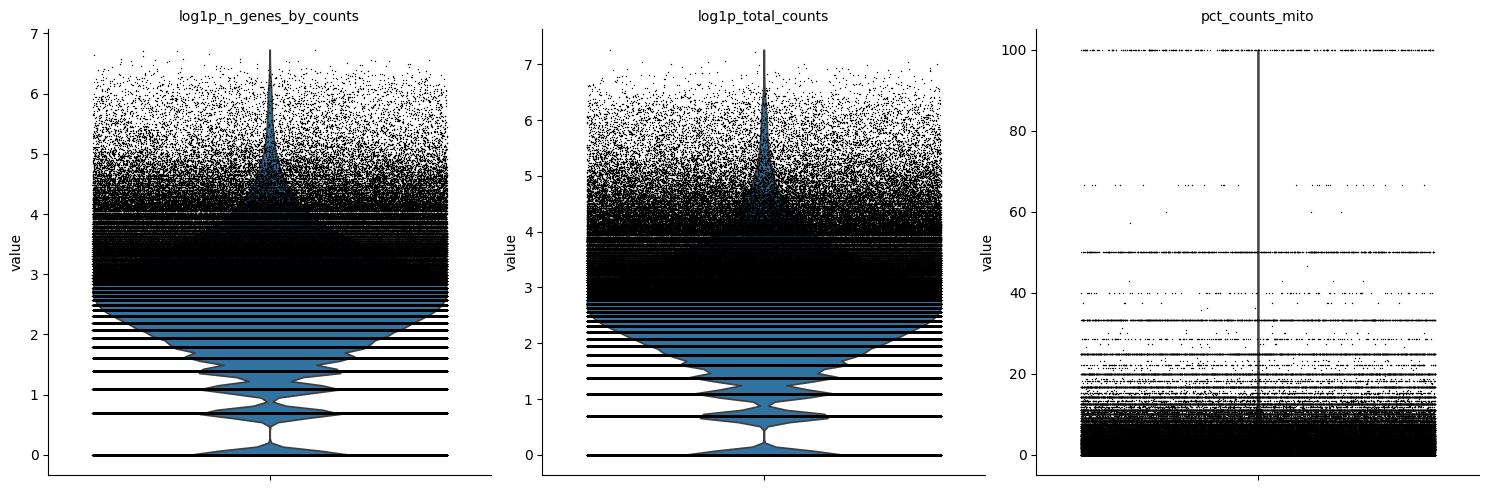

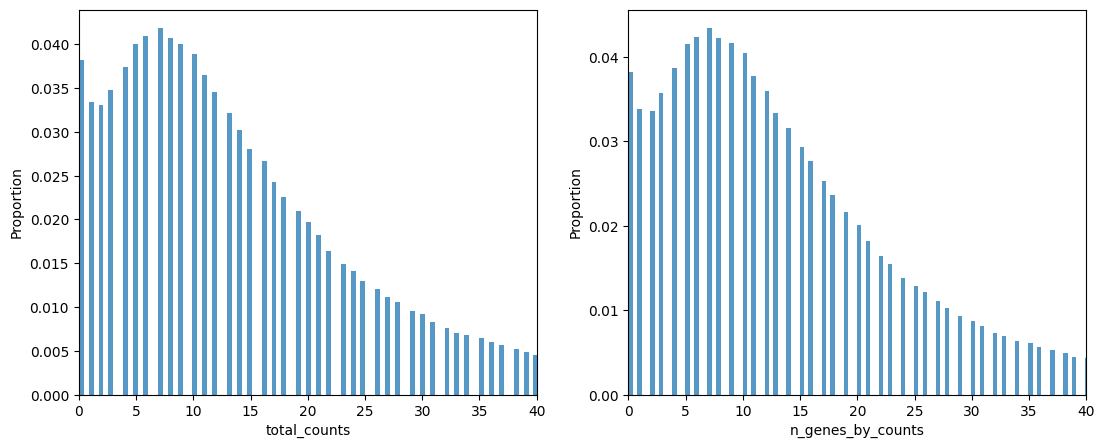

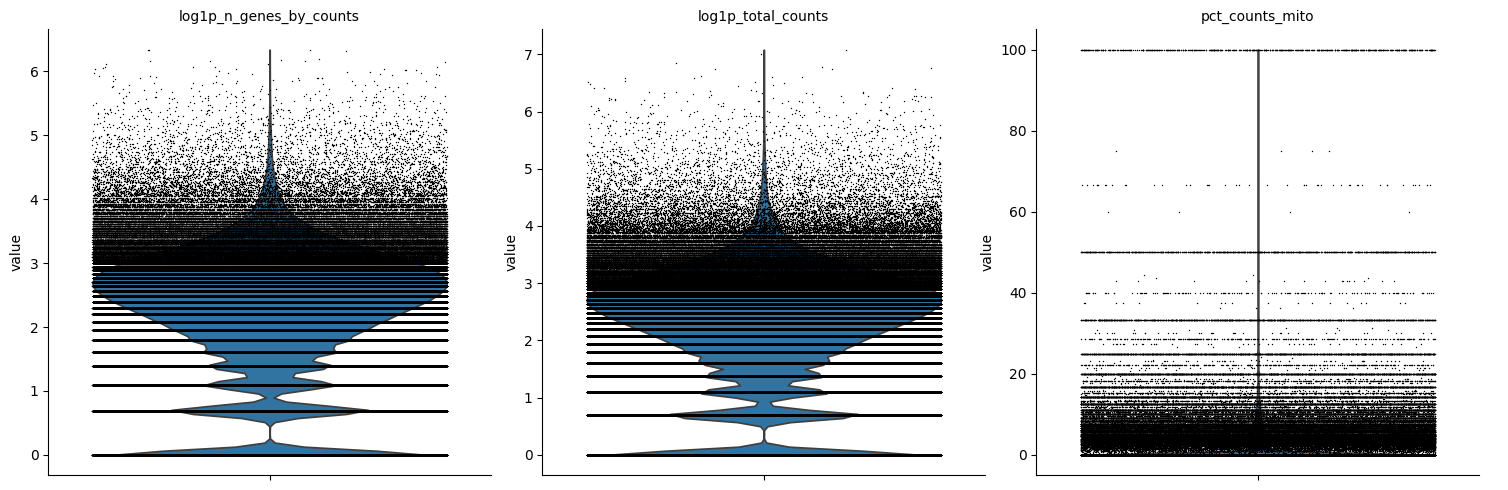

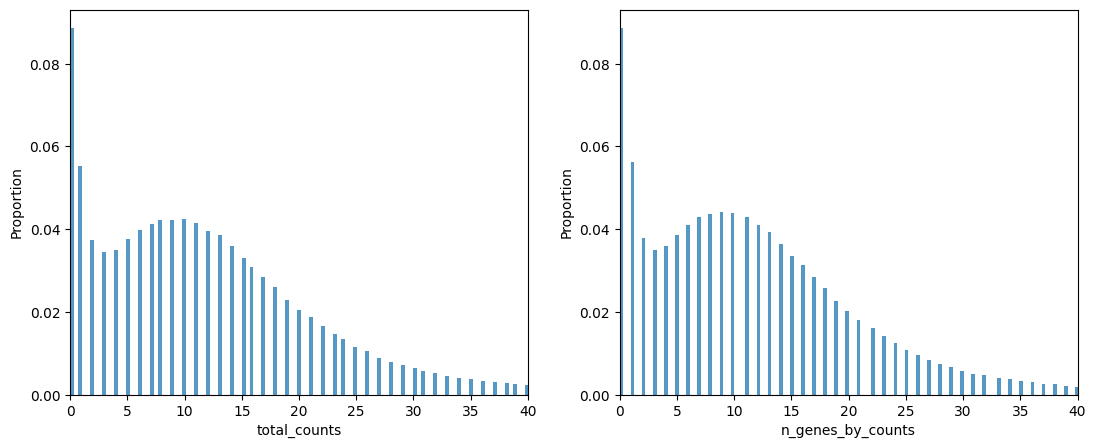

In [ ]:
for samp in samples:
    adata = sdatas[samp]["square_008um"].copy()

    # calculated QCs
    sc.pp.calculate_qc_metrics(adata, inplace=True, percent_top=[20])
    Filter_GeneGroup(adata)

    # plot QCs
    sc.pl.violin(
        adata,
        ["log1p_n_genes_by_counts", "log1p_total_counts", "pct_counts_mito"],
        jitter=0.4,
        multi_panel=True,
    )

    # f, axs = plt.subplots(1, 2, figsize=(13, 5), layout="constrained")
    # sns.histplot(
    #     adata.obs["total_counts"],
    #     kde=True,
    #     ax=axs[0],
    #     stat="proportion",
    #     # log_scale=True,
    # )
    # axs[0].set_xlim(0, 200)

    # sns.histplot(
    #     adata.obs["n_genes_by_counts"],
    #     kde=True,
    #     ax=axs[1],
    #     stat="proportion",
    #     # log_scale=True,
    # )
    # axs[1].set_xlim(0, 200)

    f, axs = plt.subplots(1, 2, figsize=(13, 5))
    sns.histplot(adata.obs["total_counts"], ax=axs[0], stat="proportion")
    axs[0].set_xlim(0, 40)
    sns.histplot(adata.obs["n_genes_by_counts"], ax=axs[1], stat="proportion")
    axs[1].set_xlim(0, 40)

CPU times: user 2.35 s, sys: 64.4 ms, total: 2.41 s
Wall time: 2.4 s


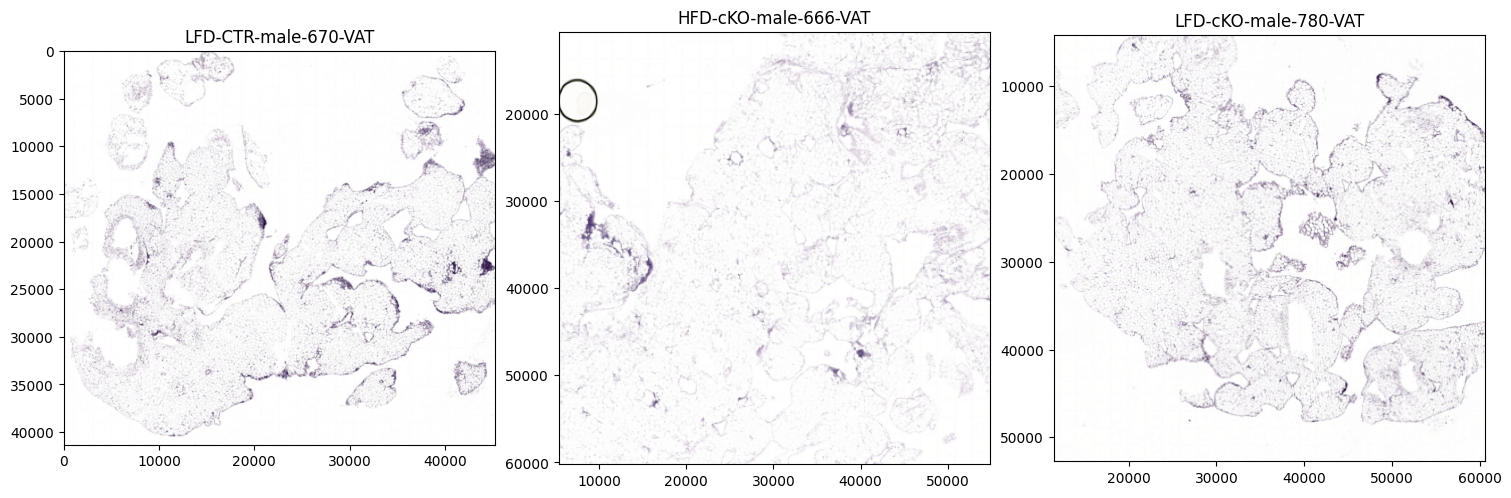

In [12]:
%%time

# View images
f, axs = plt.subplots(
    1, len(samples), figsize=(len(samples) * 5, 5), layout="constrained"
)
for i, samp in enumerate(samples):
    sdatas[samp].pl.render_images("queried_lowres").pl.show(
        coordinate_systems=samp, ax=axs[i]
    )

In [131]:
# add adata metadata

# # clear to
# for samp in samples:
#     print(sdatas[samp]["square_008um"].obs.columns[:-8])
#     sdatas[samp]["square_008um"].obs = sdatas[samp]["square_008um"].obs.loc[
#         :, sdatas[samp]["square_008um"].obs.columns[:-8]
#     ]

for samp in samples:
    adata = sdatas[samp].tables["square_008um"]

    # whole tissue barcodes
    adata.obs["in EH whole tissue"] = adata.obs_names.isin(
        barcodes[samp]["EH whole tissue.csv"].index
    )

    # autocluster barcodes
    adata.obs["in JB autocluster"] = adata.obs_names.isin(
        barcodes[samp]["JB autocluster.csv"].index
    )
    adata.obs = adata.obs.join(barcodes[samp]["JB autocluster.csv"], how="left")
    adata.obs["Autocluster Labels"] = adata.obs["Autocluster Labels"].fillna(
        "not present"
    )
    adata.obs["Autocluster Labels"] = adata.obs["Autocluster Labels"].astype(str)

    # drawn ROIs
    adata.obs["in JB drawn"] = adata.obs_names.isin(
        barcodes[samp]["JB drawn.csv"].index
    )
    adata.obs = adata.obs.join(barcodes[samp]["JB drawn.csv"], how="left")
    adata.obs["ROI Labels"] = adata.obs["ROI Labels"].fillna("not present")
    adata.obs["ROI Labels"] = adata.obs["ROI Labels"].astype(str)

    idents = adata.obs["Identifier"].str.split("-|_", expand=True)
    adata.obs["Diet"] = idents[0]
    adata.obs["Model"] = idents[1]
    adata.obs["Group"] = adata.obs["Diet"] + "-" + adata.obs["Model"]
    adata.layers["counts"] = adata.X
    print(pd.crosstab(adata.obs["in EH whole tissue"], adata.obs["in JB autocluster"]))

sdatas[samples[0]].tables["square_008um"].obs.head(10)

in JB autocluster    False   True 
in EH whole tissue                
False               393815    9402
True                136362  127525
in JB autocluster    False  True 
in EH whole tissue               
False               127441   7416
True                369254  75482
in JB autocluster    False  True 
in EH whole tissue               
False               191509   1297
True                305210  21246


in_tissue  array_row  array_col  location_id  \
s_008um_00269_00526-1          1        269        526            0   
s_008um_00260_00253-1          1        260        253            1   
s_008um_00433_00599-1          1        433        599            2   
s_008um_00819_00322-1          1        819        322            3   
s_008um_00266_00304-1          1        266        304            4   
s_008um_00154_00449-1          1        154        449            5   
s_008um_00359_00037-1          1        359         37            6   
s_008um_00469_00254-1          1        469        254            7   
s_008um_00674_00375-1          1        674        375            8   
s_008um_00226_00670-1          1        226        670            9   

                                                  region  \
s_008um_00269_00526-1  LFD-CTR-male-670-VAT_square_008um   
s_008um_00260_00253-1  LFD-CTR-male-670-VAT_square_008um   
s_008um_00433_00599-1  LFD-CTR-male-670-VAT_square_008um   
s_008um_00819_00322-1  LFD-CTR-male-670-VAT_square_008um   
s_008um_00266_00304-1  LFD-CTR-male-670-VAT_square_008um   
s_008um_00154_00449-1  LFD-CTR-male-670-VAT_square_008um   
s_008um_00359_00037-1  LFD-CTR-male-670-VAT_square_008um   
s_008um_00469_00254-1  LFD-CTR-male-670-VAT_square_008um   
s_008um_00674_00375-1  LFD-CTR-male-670-VAT_square_008um   
s_008um_00226_00670-1  LFD-CTR-male-670-VAT_square_008um   

                                 Identifier  in EH whole tissue  \
s_008um_00269_00526-1  LFD-CTR-male-670-VAT               False   
s_008um_00260_00253-1  LFD-CTR-male-670-VAT               False   
s_008um_00433_00599-1  LFD-CTR-male-670-VAT                True   
s_008um_00819_00322-1  LFD-CTR-male-670-VAT               False   
s_008um_00266_00304-1  LFD-CTR-male-670-VAT               False   
s_008um_00154_00449-1  LFD-CTR-male-670-VAT               False   
s_008um_00359_00037-1  LFD-CTR-male-670-VAT               False   
s_008um_00469_00254-1  LFD-CTR-male-670-VAT                True   
s_008um_00674_00375-1  LFD-CTR-male-670-VAT               False   
s_008um_00226_00670-1  LFD-CTR-male-670-VAT               False   

                       in JB autocluster Autocluster Labels  in JB drawn  \
s_008um_00269_00526-1              False        not present        False   
s_008um_00260_00253-1              False        not present        False   
s_008um_00433_00599-1              False        not present        False   
s_008um_00819_00322-1              False        not present        False   
s_008um_00266_00304-1              False        not present        False   
s_008um_00154_00449-1              False        not present        False   
s_008um_00359_00037-1              False        not present        False   
s_008um_00469_00254-1               True       adipo/ neuro        False   
s_008um_00674_00375-1              False        not present        False   
s_008um_00226_00670-1              False        not present        False   

                        ROI Labels Diet Model    Group  
s_008um_00269_00526-1  not present  LFD   CTR  LFD-CTR  
s_008um_00260_00253-1  not present  LFD   CTR  LFD-CTR  
s_008um_00433_00599-1  not present  LFD   CTR  LFD-CTR  
s_008um_00819_00322-1  not present  LFD   CTR  LFD-CTR  
s_008um_00266_00304-1  not present  LFD   CTR  LFD-CTR  
s_008um_00154_00449-1  not present  LFD   CTR  LFD-CTR  
s_008um_00359_00037-1  not present  LFD   CTR  LFD-CTR  
s_008um_00469_00254-1  not present  LFD   CTR  LFD-CTR  
s_008um_00674_00375-1  not present  LFD   CTR  LFD-CTR  
s_008um_00226_00670-1  not present  LFD   CTR  LFD-CTR

In [132]:
# subset for whole tissue
for s in samples:
    adata = sdatas[s]["square_008um"]
    adata = adata[adata.obs["in EH whole tissue"]]

In [ ]:
%%time
gene_name = "Igkc"

new_cmap = set_zero_in_cmap_to_transparent(cmap="viridis")

f, axs = plt.subplots(
    1, len(samples), figsize=(len(samples) * 5, 5), layout="constrained"
)
for i, samp in enumerate(samples):
    sdatas[samp].pl.render_shapes(
        f"{samp}_square_008um",
        color=gene_name,
        cmap=new_cmap,
    ).pl.show(coordinate_systems=samp, ax=axs[i])

In [143]:
def Filter_QC(
    adata: AnnData,
    GenePerCell: int = 250,
    CountPerCell: int = 500,
    CellPerGene: int = 10,
    verbose: bool = False,
):

    start = adata.shape[0]
    sc.pp.filter_cells(adata, min_genes=GenePerCell)
    sc.pp.filter_cells(adata, min_counts=CountPerCell)
    sc.pp.filter_genes(adata, min_cells=CellPerGene)
    adata.var_names_make_unique()
    if verbose is True:
        print(
            f"Cells removed by gene/count filters: {start - adata.shape[0]} ({(start - adata.shape[0])/start*100:.2f}%)"
        )
    return adata


def Filter_GeneGroup(
    adata: AnnData,
    key: str = "mito",
    marker: str = "mt",
    verbose: bool = False,
    perc_threshold: float = None,
):

    # assign mito genes
    adata.var[key] = adata.var_names.str.startswith(marker)

    # calculate & save metrics
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=[key], inplace=True, percent_top=[20], log1p=True
    )
    remove = [f"total_counts_{key}", f"log1p_total_counts_{key}"]
    adata.obs = adata.obs.loc[:, ~adata.obs.columns.isin(remove)]

    # filter
    if perc_threshold is not None:
        thresholded = adata.obs[f"pct_counts_{key}"] <= perc_threshold
        if verbose is True:
            print(
                f"Cells with >{perc_threshold}% {key} genes: {adata.shape[0]-np.sum(thresholded)} ({(adata.shape[0]-np.sum(thresholded))/adata.shape[0]*100:.2f}%)"
            )
        adata = adata[thresholded]

    return adata

In [ ]:
runFilters = True
adatas = {}

# Filter out annoying IgG genes
for samp in samples:
    adata = sdatas[samp]["square_008um"].copy()
    adata = adata[:, adata.var_names.str.contains("Igh|Igk|Jchain") == 0]
    adatas[samp] = adata

# Standard QC Filters
filters = {"GenesPerCell": 70, "ReadsPerCell": 0, "CellsPerGene": 10, "Mito%": 15}
for samp in samples:
    if runFilters is True:
        Filter_QC(
            adatas[samp],
            GenePerCell=filters["GenesPerCell"],
            CountPerCell=filters["ReadsPerCell"],
            CellPerGene=filters["CellsPerGene"],
            verbose=True,
        )
        Filter_GeneGroup(
            adatas[samp],
            key="mito",
            marker="mt",
            verbose=True,
            perc_threshold=filters["Mito%"],
        )

    print(f"Remaining cells: {adatas[samp].shape[0]}\n")

Cells removed by gene/count filters: 630431 (94.50%)
Cells with >15% mito genes: 0 (0.00%)
Remaining cells: 36673

Cells removed by gene/count filters: 559525 (96.54%)
Cells with >15% mito genes: 0 (0.00%)
Remaining cells: 20068

Cells removed by gene/count filters: 515548 (99.28%)
Cells with >15% mito genes: 0 (0.00%)
Remaining cells: 3714



In [ ]:
# plot target genes upon images
f, axs = plt.subplots(
    1, len(samples), figsize=(len(samples) * 5, 5), layout="constrained"
)

for i, samp in enumerate(samples):
    sdatas[samp].pl.render_images("queried_hires").pl.render_shapes(
        f"{samp}_square_008um",
        color="Cma1",
        cmap=new_cmap,
    ).pl.show(coordinate_systems=f"{samp}_downscaled_hires", ax=axs[i])

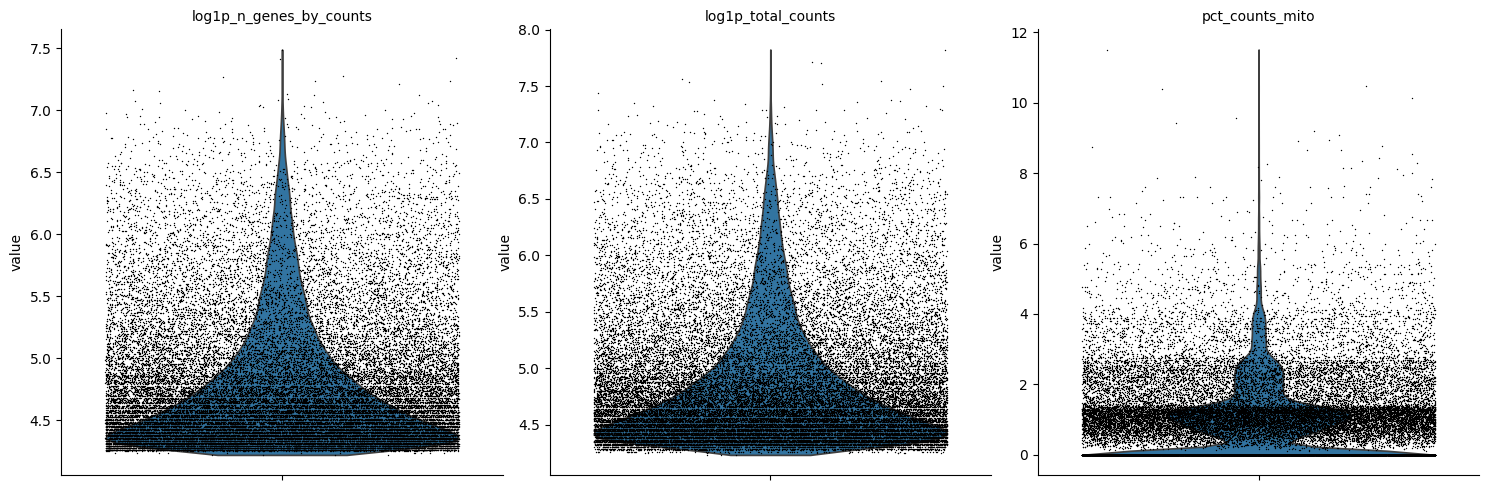

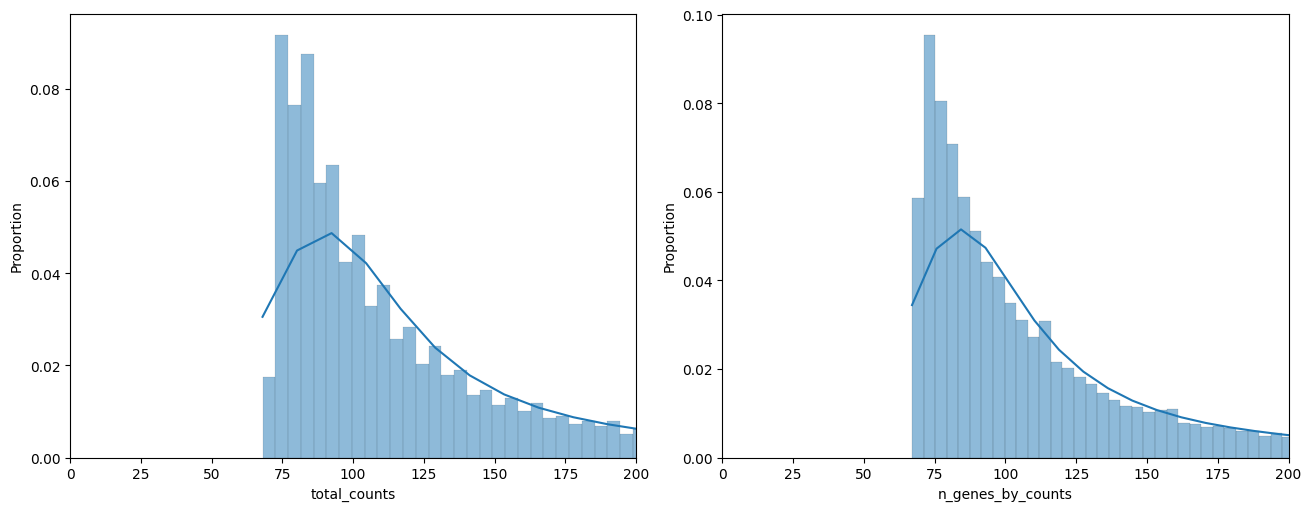

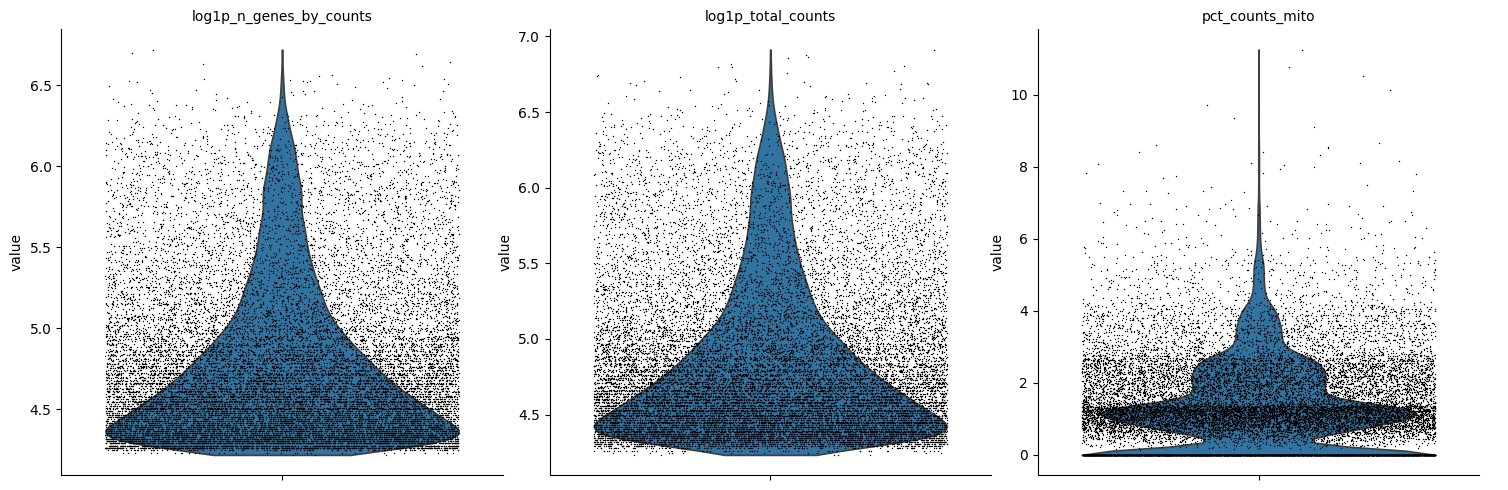

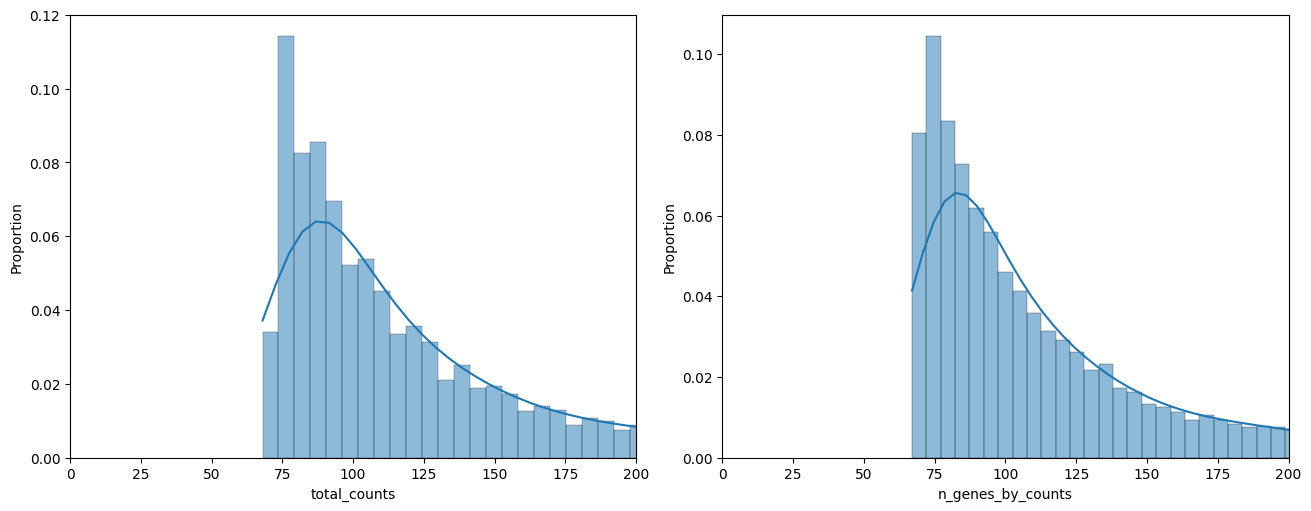

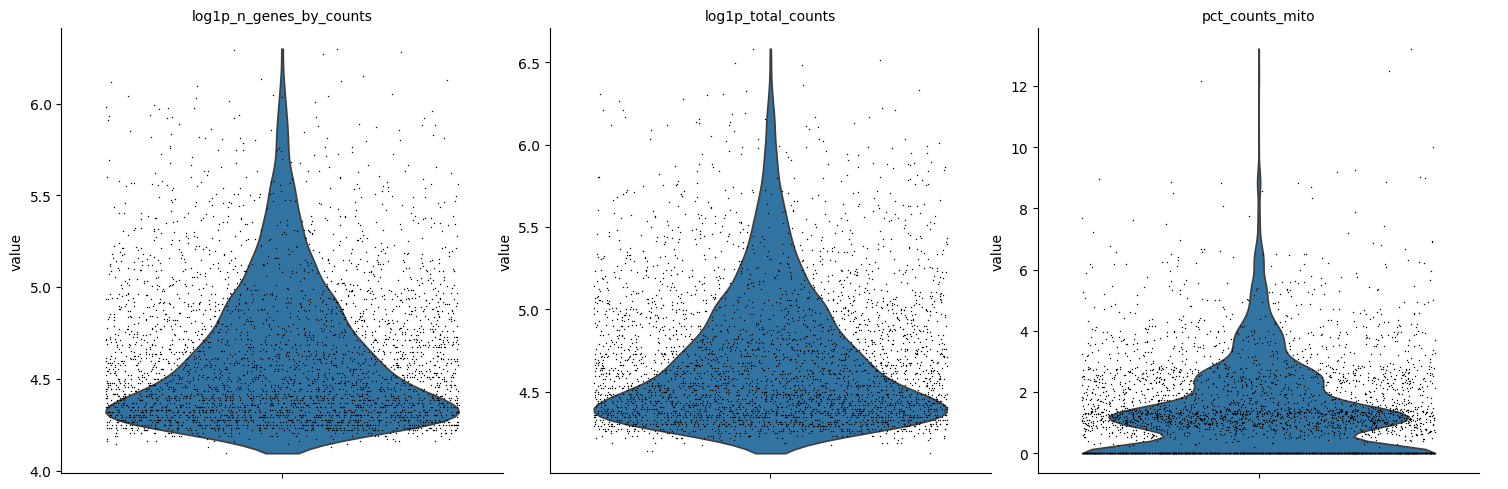

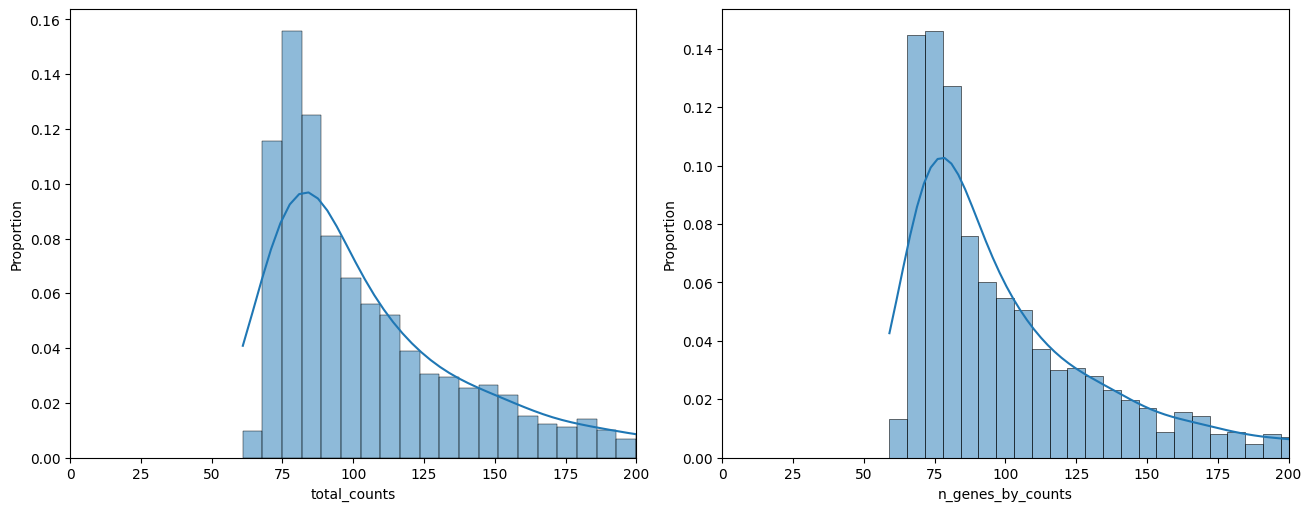

In [172]:
# QC check 2
# adata = sdatas[samp].tables["square_008um"].copy()
for samp in samples:
    adata = adatas[samp].copy()

    # calculated QCs
    sc.pp.calculate_qc_metrics(adata, inplace=True, percent_top=[20])
    Filter_GeneGroup(adata)

    # plot QCs
    sc.pl.violin(
        adata,
        ["log1p_n_genes_by_counts", "log1p_total_counts", "pct_counts_mito"],
        jitter=0.4,
        multi_panel=True,
    )

    f, axs = plt.subplots(1, 2, figsize=(13, 5), layout="constrained")
    sns.histplot(
        adata.obs["total_counts"],
        kde=True,
        ax=axs[0],
        stat="proportion",
        # log_scale=True,
    )
    axs[0].set_xlim(0, 200)

    sns.histplot(
        adata.obs["n_genes_by_counts"],
        kde=True,
        ax=axs[1],
        stat="proportion",
        # log_scale=True,
    )
    axs[1].set_xlim(0, 200)

In [ ]:
# View unintegrated version

adata_unInt = sc.concat(
    [sdatas[samp]["square_008um"] for samp in samples],
    join="outer",
)
adata_unInt.uns["QC filters"] = filters


# order categories
order_obs(adata_unInt, "Diet", ["LFD", "HFD"])
order_obs(adata_unInt, "Model", ["CTR", "cKO"])
order_obs(adata_unInt, "Group", ["LFD-CTR", "LFD-cKO", "HFD-cKO"])

Normalize(adata_unInt, kind="log1p")
FindVariableGenes(
    adata_unInt, kind="seurat_v3", batch_column="Identifier", n_features=100
)

from pacmap import LocalMAP

sc.pp.neighbors(adata_unInt)
sc.tl.umap(adata_unInt, key_added=f"UMAP_unintegrated")
lm = LocalMAP()
adata.obsm[f"LocalMAP_unintegrated"] = lm.fit_transform(adata.X.toarray())

plotting = ["Identifier", "log1p_total_counts"]
sc.pl.embedding(adata, "LocalMAP_unintegrated", color=plotting)
sc.pl.embedding(adata, "UMAP_unintegrated", color=plotting)

### Integration

In [177]:
batch_column = "Identifier"
hvg_kind = "seurat_v3"
int_kind = "harmony"

adata_FULL_WT = sc.concat(
    [adatas[samp] for samp in samples],
    join="outer",
)
adata_FULL_WT.uns["QC filters"] = filters


# order categories
order_obs(adata_FULL_WT, "Diet", ["LFD", "HFD"])
order_obs(adata_FULL_WT, "Model", ["CTR", "cKO"])
order_obs(adata_FULL_WT, "Group", ["LFD-CTR", "LFD-cKO", "HFD-cKO"])

Normalize(adata_FULL_WT, kind="log1p")
FindVariableGenes(
    adata_FULL_WT, kind=hvg_kind, batch_column=batch_column, n_features=500
)
print(adata_FULL_WT.var_names[adata_FULL_WT.var["highly_variable"]].to_list(), "\n")

Integrate(adata_FULL_WT, kind=int_kind, batch_column=batch_column, use_var_genes=False)
Visualize(adata_FULL_WT)

Saving normalized counts in layer 'normalized'.
Finding HVGs...
['Acad10', 'Acap1', 'Accs', 'Acod1', 'Acsm3', 'Adam8', 'Adamts9', 'Adamtsl2', 'Adgrl1', 'Adrb3', 'Ahsa2', 'Aldh1a2', 'Alox15', 'Alox5', 'Alpl', 'Angptl8', 'Ankrd10', 'Ankrd6', 'Anpep', 'Apod', 'Apol10b', 'Apol7c', 'Aqp1', 'Arg1', 'Arl2', 'Armc6', 'Arrdc3', 'Asap3', 'Avpi1', 'B3gntl1', 'Best1', 'Bfsp2', 'Bmp1', 'Brd3', 'Brms1l', 'C1qtnf6', 'Cables1', 'Cacnb3', 'Cadm4', 'Capn3', 'Card14', 'Casp7', 'Ccl19', 'Ccl2', 'Ccl21a', 'Ccl22', 'Ccl5', 'Ccl9', 'Ccn1', 'Ccp110', 'Cd163', 'Cd19', 'Cd209a', 'Cd209b', 'Cd209f', 'Cd37', 'Cd4', 'Cd5l', 'Cd68', 'Cd7', 'Cd74', 'Cd79a', 'Cd79b', 'Cd8b1', 'Cdk5rap3', 'Cdkl4', 'Cdkn2a', 'Ceacam16', 'Cenpi', 'Cenpq', 'Cenpx', 'Cep126', 'Cfap97', 'Chga', 'Cldn1', 'Cldn11', 'Cldn5', 'Clec9a', 'Clu', 'Cma1', 'Cmah', 'Cnr1', 'Coch', 'Col3a1', 'Col8a2', 'Coro1a', 'Cox18', 'Cpa3', 'Cpsf4', 'Cr2', 'Creld2', 'Crtam', 'Cst6', 'Ctsk', 'Ctsl', 'Ctss', 'Cxcl13', 'Cxcl14', 'Cxcl2', 'Cxcl9', 'Cxcr3', 'Cxcr4', 'C

2025-08-15 15:19:02,229 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-08-15 15:19:09,269 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-08-15 15:19:09,538 - harmonypy - INFO - Iteration 1 of 50
INFO:harmonypy:Iteration 1 of 50
2025-08-15 15:19:33,655 - harmonypy - INFO - Iteration 2 of 50
INFO:harmonypy:Iteration 2 of 50
2025-08-15 15:19:58,158 - harmonypy - INFO - Iteration 3 of 50
INFO:harmonypy:Iteration 3 of 50
2025-08-15 15:20:22,294 - harmonypy - INFO - Iteration 4 of 50
INFO:harmonypy:Iteration 4 of 50
2025-08-15 15:20:34,120 - harmonypy - INFO - Iteration 5 of 50
INFO:harmonypy:Iteration 5 of 50
2025-08-15 15:20:42,922 - harmonypy - INFO - Iteration 6 of 50
INFO:harmonypy:Iteration 6 of 50
2025-08-15 15:20:51,619 - harmonypy - INFO - Converged after 6 iterations
INFO:harmonypy:Converged after 6 iterations


Starting UMAP...
Starting LocalMAP...


AnnData object with n_obs × n_vars = 60455 × 12866
    obs: 'in_tissue', 'array_row', 'array_col', 'location_id', 'region', 'Identifier', 'in EH whole tissue', 'in JB autocluster', 'Autocluster Labels', 'in JB drawn', 'ROI Labels', 'Diet', 'Model', 'Group', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mito'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'QC filters', 'methods', 'log1p', 'hvg', 'pca', 'neighbors', 'UMAP'
    obsm: 'spatial', 'X_pca', 'integrated', 'UMAP', 'LocalMAP'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'distances', 'connectivities'

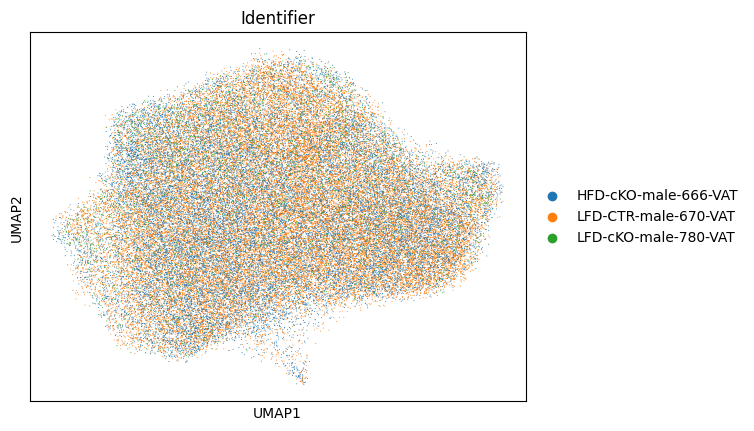

In [178]:
sc.pl.embedding(adata_FULL_WT, basis="UMAP", color="Identifier")

### Cluster

In [196]:
%%time
res = 1
cluster_key = f"leiden_{res:.1f}"
print(cluster_key)
sc.tl.leiden(adata_FULL_WT, resolution=res, key_added=cluster_key)

leiden_1.0
CPU times: user 2min 55s, sys: 918 ms, total: 2min 56s
Wall time: 2min 55s


CPU times: user 53.4 s, sys: 225 ms, total: 53.6 s
Wall time: 8.09 s


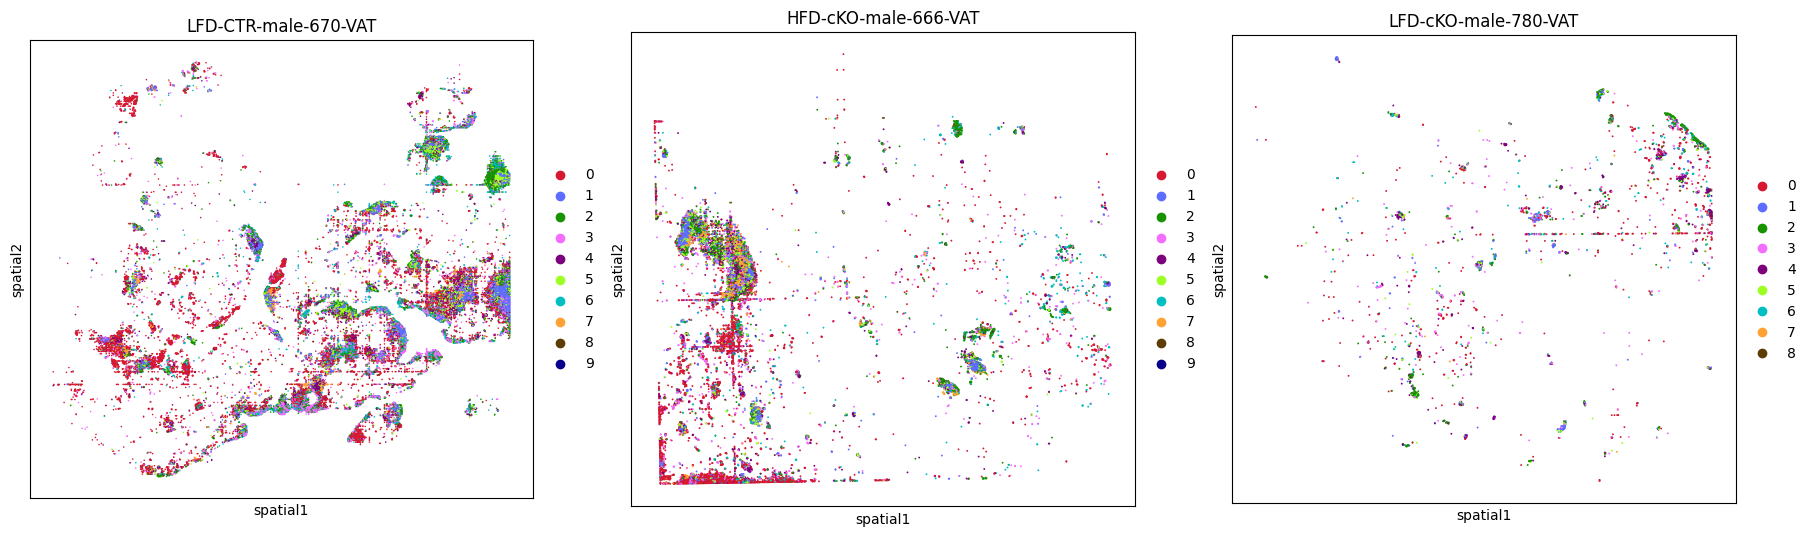

In [197]:
%%time
# res = 1
cluster_key = f"leiden_{res:.1f}"

f, axs = plt.subplots(
    1, len(samples), figsize=(len(samples) * 6, 6), layout="constrained"
)
for n, id in enumerate(adata_FULL_WT.obs["Identifier"].unique()):
    sc.pl.spatial(
        adata_FULL_WT[adata_FULL_WT.obs["Identifier"] == id],
        color=cluster_key,
        spot_size=150 if n == 0 else 200,
        ax=axs[n],
        show=False,
        palette=color_gen(adata_FULL_WT.obs[cluster_key].unique()).to_list(),
        title=id,
    )

In [181]:
# SAVE
adata_FULL_WT.write(
    os.path.join(DATADIR, "processed", "combined", "raw_processed-V5 WT_filter70.h5ad")
)

In [ ]:
# LOAD
adata_FULL_WT = sc.read_h5ad(
    os.path.join(DATADIR, "processed", "combined", "raw_processed-V5 WT_filter70.h5ad")
)

### Visualize

<Axes: title={'center': 'Model'}, xlabel='LocalMAP1', ylabel='LocalMAP2'>

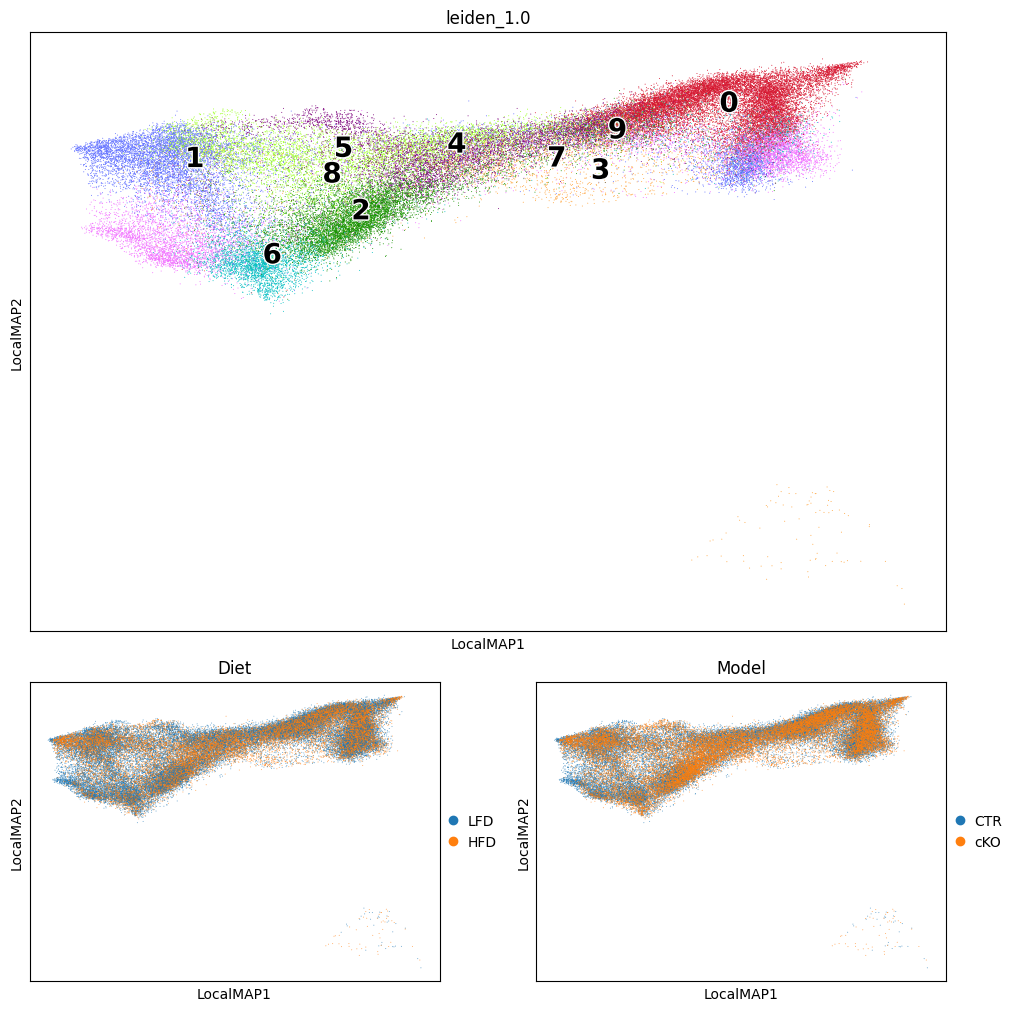

In [220]:
res = 1
cluster_key = f"leiden_{res:.1f}"
embedding = "LocalMAP"

cluster_c = color_gen(adata_FULL_WT.obs[cluster_key])
f = plt.figure(figsize=(10, 10), layout="constrained")

axs = f.subplots(3, 2)
gs = axs[0, 0].get_gridspec()
for rs in axs[:]:
    for ax in rs[:]:
        ax.remove()

# Large LocalMAP plot
ax = f.add_subplot(gs[:2, :])
sc.pl.embedding(
    adata_FULL_WT,
    basis=embedding,
    color=[cluster_key],
    ax=ax,
    show=False,
    legend_loc="on data",
    legend_fontoutline=2,
    legend_fontsize=20,
    palette=cluster_c.to_list(),
)
# ax = f.add_subplot(gs[2, 0])
# sc.pl.embedding(
#     adata_FULL_WT,
#     basis=embedding,
#     color=["Group"],
#     ax=ax,
#     show=False,
#     alpha=0.7,
# )
ax = f.add_subplot(gs[2, 0])
sc.pl.embedding(
    adata_FULL_WT, basis=embedding, color=["Diet"], ax=ax, show=False, alpha=0.7
)
ax = f.add_subplot(gs[2, 1])
sc.pl.embedding(
    adata_FULL_WT, basis=embedding, color=["Model"], ax=ax, show=False, alpha=0.7
)

In [200]:
variable_genes = (
    adata_FULL_WT.var[adata_FULL_WT.var["highly_variable"]].sort_values(
        "highly_variable_rank"
    )
).index
variable_genes

Index(['Iglc1', 'Iglc2', 'Cst6', 'Hbb-bs', 'Mmp12', 'Gpnmb', 'Hba-a2', 'Slpi',
       'Mcpt4', 'Marco',
       ...
       'Fam222b', 'Nuggc', 'Pdlim3', 'Usp42', 'Gzma', 'Ly6g5b', 'Cd4',
       'Cldn11', 'Noc3l', 'Gimap3'],
      dtype='object', length=500)

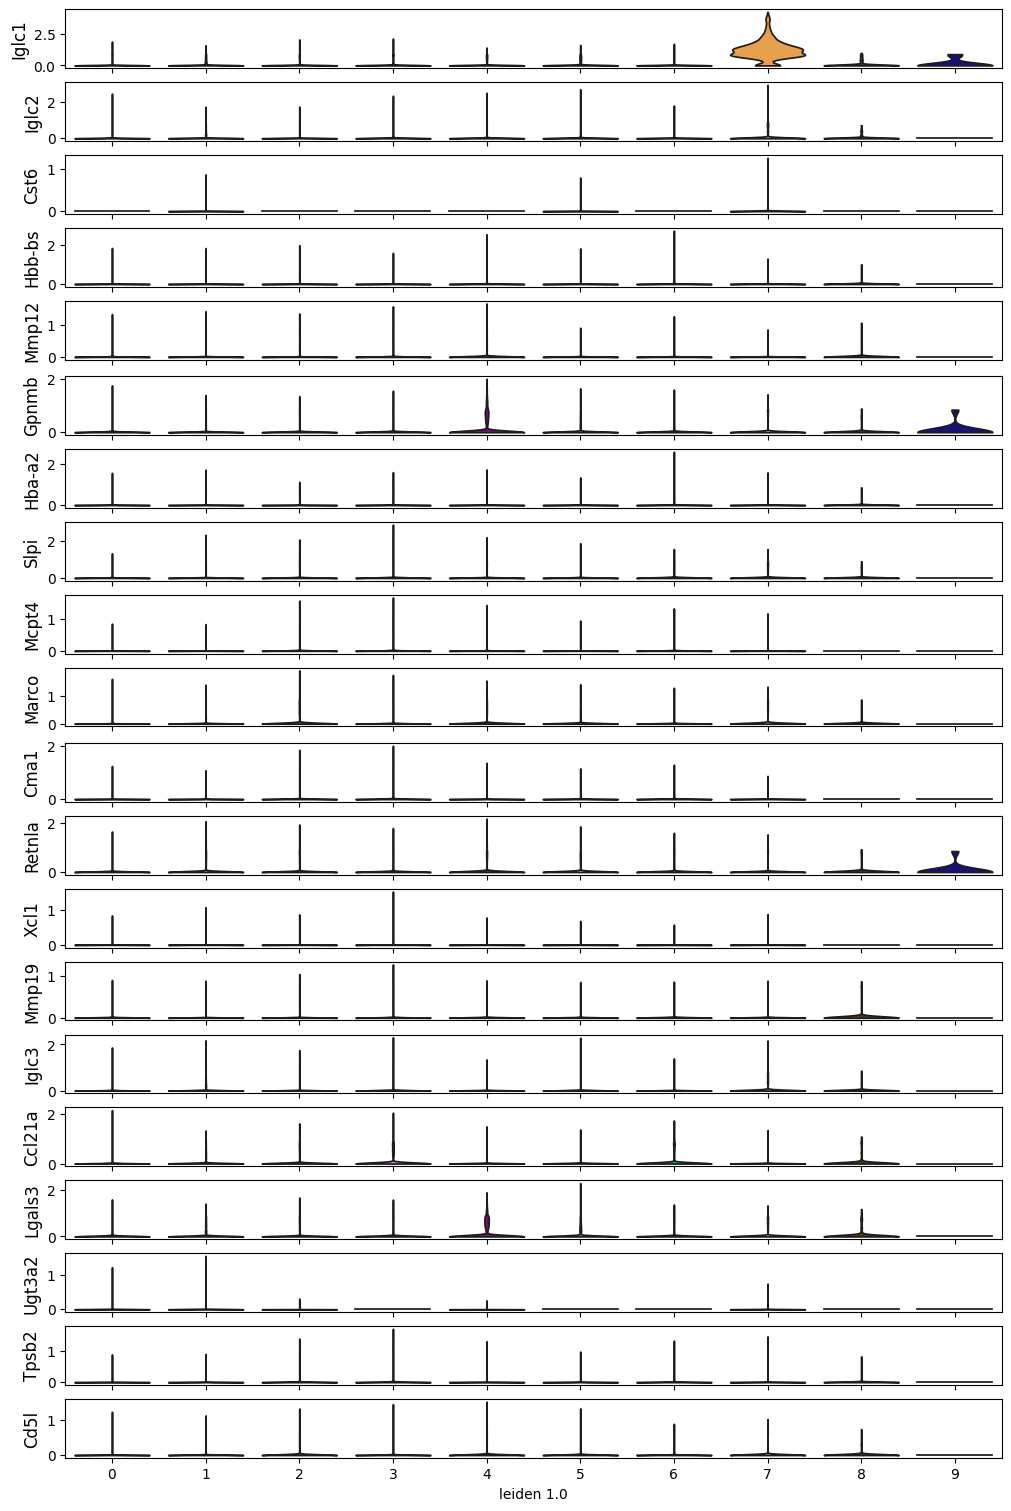

In [201]:
def plot_violinplot(
    adata,
    markers,
    group: str,
    f,
    layer: str = "normalized",
    useStripPlot=True,
    bracket_params=None,
):
    axs = f.subplots(len(markers), 1)
    for n, m in enumerate(markers):
        sc.pl.violin(
            adata,
            m,
            groupby=group,
            use_raw=False,
            layer=layer,
            show=False,
            ax=axs[n],
            stripplot=useStripPlot,
        )
        if n < len(markers) - 1:
            axs[n].set_xlabel("")
            axs[n].set_xticklabels([""] * len(axs[n].get_xticklabels()))
        axs[n].set_ylabel(axs[n].get_ylabel(), size=12)

    if bracket_params is not None:
        ratios = bracket_params["ratio"] / np.sum(bracket_params["ratio"])
        ends = np.append(0, np.cumsum(ratios))
        bar_label_locs = [ends[i] + ratios[i] / 2 for i in range(len(ratios))]
        bar_bracket_widths = ratios * f.get_size_inches()[0] * 3.1

        axs = f.get_axes()
        for (
            n,
            label,
        ) in enumerate(bracket_params["labels"]):
            axs[-1].annotate(
                label,
                xy=(bar_label_locs[n], -bracket_params["bracket_y"]),
                xytext=(bar_label_locs[n], -bracket_params["label_y"]),
                xycoords="axes fraction",
                ha="center",
                va="bottom",
                bbox=dict(boxstyle="square", fc="none", color="none"),
                arrowprops=dict(
                    arrowstyle=f"-[, widthB={bar_bracket_widths[n]}, lengthB=0.3",
                    lw=1.0,
                    color="k",
                ),
            )
        axs[-1].set_xlabel(axs[-1].get_xlabel(), labelpad=bracket_params["padding"])

    return


f = plt.figure(figsize=(10, 15), layout="constrained")

# markers = [
#     "Adipoq",
#     "Pdgfra",
#     "Upk3b",
#     "Cdh5",
#     "Rgs5",
#     "Adgre1",
#     "Flt3",
#     "Cpa3",
#     "Skap1",
#     "Igkc",
# ]
plot_violinplot(
    adata_FULL_WT,
    variable_genes[:20],
    cluster_key,
    f,
    useStripPlot=False,
    layer="normalized",
)

dendrogram data not found (using key=dendrogram_leiden_1.0). Running `sc.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `sc.tl.dendrogram` independently.


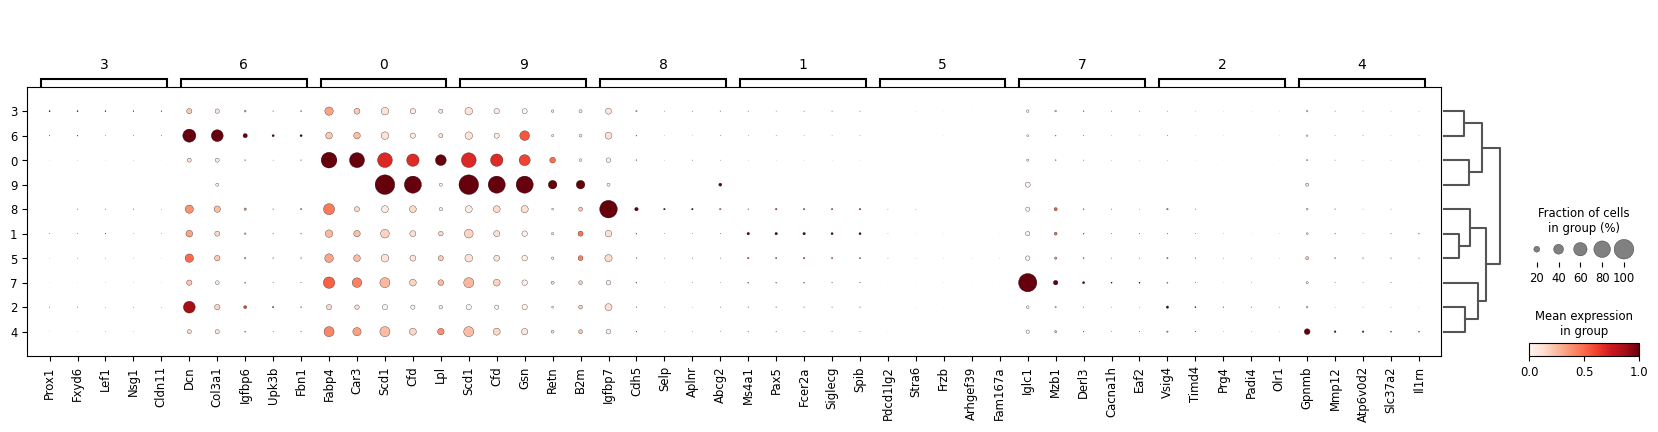

In [202]:
sc.tl.rank_genes_groups(
    adata_FULL_WT,
    groupby=cluster_key,
    key_added=f"de_{cluster_key}",
    use_raw=False,
    layer="normalized",
    method="wilcoxon",
)

sc.pl.rank_genes_groups_dotplot(
    adata_FULL_WT,
    groupby=cluster_key,
    key=f"de_{cluster_key}",
    standard_scale="var",
    n_genes=5,
    min_logfoldchange=2,
)

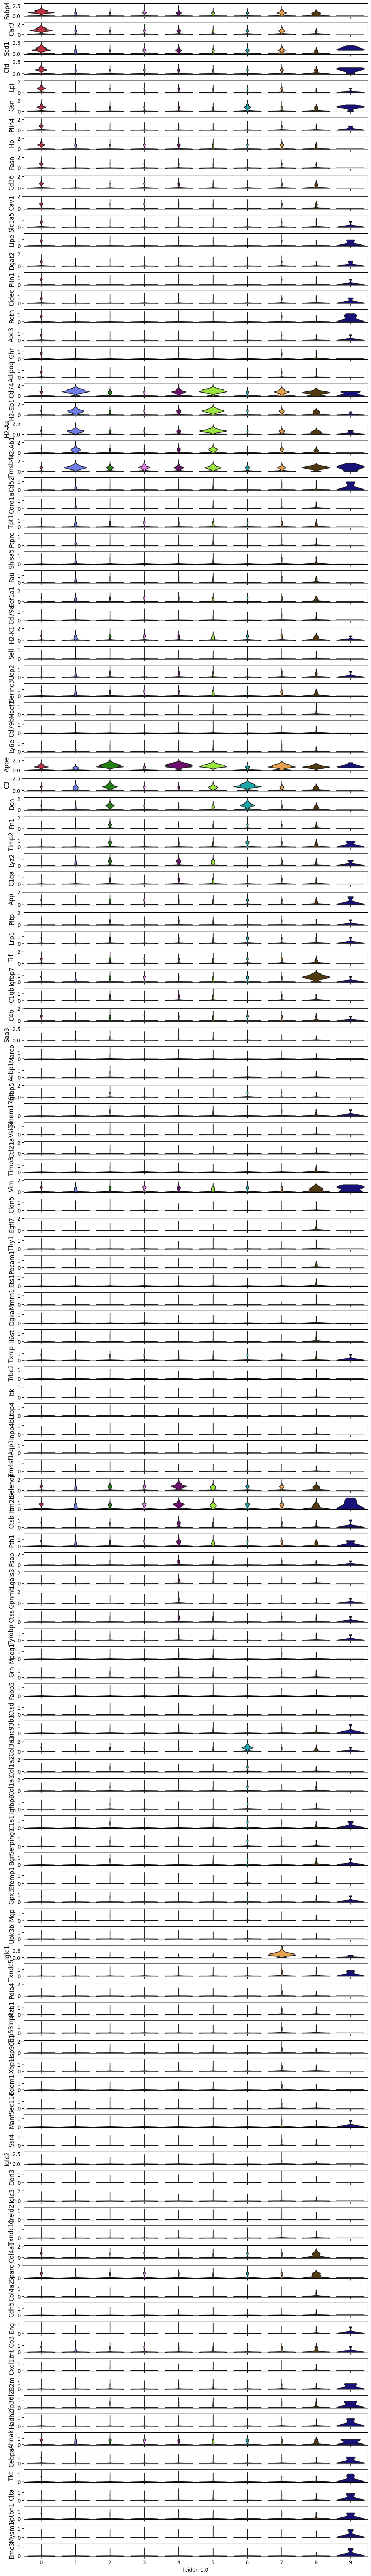

In [328]:
df = sc.get.rank_genes_groups_df(adata_FULL_WT, group=None, key=f"de_{cluster_key}")
# threshold = 1e-75
# DEGs_cutoff = df[df["pvals_adj"] < threshold].names.unique()
# print("DEGs under threshold:", len(DEGs_cutoff))

cutoff = 20
topDEGs = pd.concat(
    [tmp.nlargest(cutoff, "scores").names for _, tmp in df.groupby("group")]
).unique()

f = plt.figure(figsize=(10, 70), layout="constrained")
plot_violinplot(
    adata_FULL_WT,
    topDEGs,
    cluster_key,
    f,
    useStripPlot=False,
    layer="normalized",
)

### AUCell for bin assignment

In [ ]:
ref_dir = os.path.join(REFDIR, "custom_signatures")

collections = {
    "snRNA_SoEtAl_immuneVstromal": pd.read_csv(
        os.path.join(ref_dir, "snRNA_SoEtAl2025_DEGS-stromal_VS_immune_markers.csv"),
        index_col=0,
    ).rename(columns={"group": "source", "names": "target"}),
    "snRNA_SoEtAl_immune": pd.read_csv(
        os.path.join(ref_dir, "snRNA_SoEtAl2025_DEGS-immune_markers.csv"),
        index_col=0,
    ).rename(columns={"group": "source", "names": "target"}),
    "snRNA_SoEtAl_stromal": pd.read_csv(
        os.path.join(ref_dir, "snRNA_SoEtAl2025_DEGS-stromal_markers.csv"),
        index_col=0,
    ).rename(columns={"group": "source", "names": "target"}),
}

for name, geneset in collections.items():
    GSEA_decoupler(
        adata_FULL_WT, name, type="AUCell", geneset=geneset, remove_prefix=False
    )
adata_FULL_WT.obsm["snRNA_SoEtAl_stromal_score_aucell"].rename(
    columns={"PC/SMC": "PC-SMC"}, inplace=True
)

adata_FULL_WT

In [ ]:
scores = []
for name, geneset in collections.items():
    score = dc.pp.get_obsm(adata=adata_FULL_WT, key=f"{name}_score_aucell")
    sc.pl.embedding(
        score,
        basis="UMAP",
        color=list(geneset.source.unique()) + [cluster_key],
        cmap="Reds",
        vmax=0.15,
        ncols=2,
    )


# f = plt.figure(figsize=(len(collections) * 5, 10), layout="constrained")
# ax = f.subplots(2, len(collections)).flatten()

# for i, cond in enumerate(score.obs["Condition"].unique()):
#     tmp = score[score.obs["Condition"] == cond]
#     for j, coll in enumerate(collections):
#         sc.pl.embedding(
#             tmp,
#             basis="LocalMAP_fibro",
#             color=coll,
#             title=f"{coll}\n({cond} eWAT)",
#             vmax=np.max(score[:, coll].X),
#             ax=ax[i * len(collections) + j],
#             show=False,
#         )

In [ ]:
aucell_sets = [
    dc.pp.get_obsm(adata=adata_FULL_WT, key=f"{name}_score_aucell").var_names
    for name, _ in collections.items()
]
aucell_sets = aucell_sets[0].append(aucell_sets[1:])
aucell = sc.AnnData(
    X=np.hstack([score.X for score in scores]),
    obs=score.obs,
    var=pd.DataFrame(index=aucell_sets),
    obsm=score.obsm,
)

sc.pl.matrixplot(
    aucell,
    var_names=aucell_sets,
    groupby=cluster_key,
    dendrogram=True,
    cmap="Reds",
    # vmax=0.15,
    # standard_scale="group",
)

sc.pl.heatmap(
    aucell,
    var_names=aucell_sets,
    groupby=cluster_key,
    dendrogram=True,
    cmap="Reds",
    vmax=0.15,
)

In [ ]:
# cell type assignment via AUCell?
key = "_AUCell"
neighbor_key = "aucell_neighbors"
cluster_key = "AUCell_clusters"

sc.pp.neighbors(aucell, key_added=neighbor_key)
sc.tl.umap(aucell, key_added=f"UMAP{key}", neighbors_key=neighbor_key)

# LocalMAP
print("Starting LocalMAP...")
lm = LocalMAP()
aucell.obsm[f"LocalMAP{key}"] = lm.fit_transform(aucell.X)

sc.tl.leiden(aucell, key_added=cluster_key)
aucell.layers["original"] = aucell.X.copy()

Starting LocalMAP...


In [354]:
annotation = "raw_processed-V5 WT_filter70 AUCELL.h5ad"
aucell.write(os.path.join(DATADIR, "processed", "combined", annotation))  # LOAD
aucell = sc.read_h5ad(os.path.join(DATADIR, "processed", "combined", annotation))

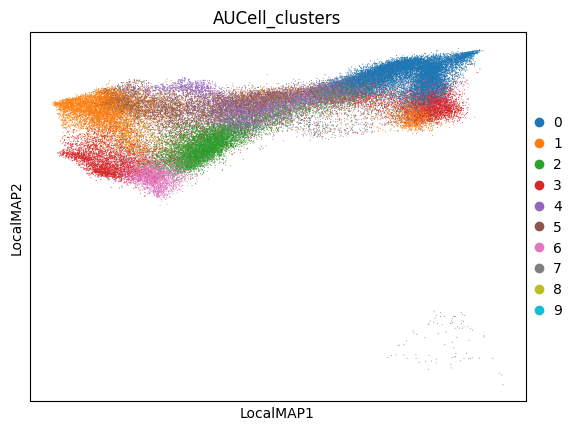

In [353]:
sc.pl.embedding(aucell, basis="LocalMAP", color="AUCell_clusters")

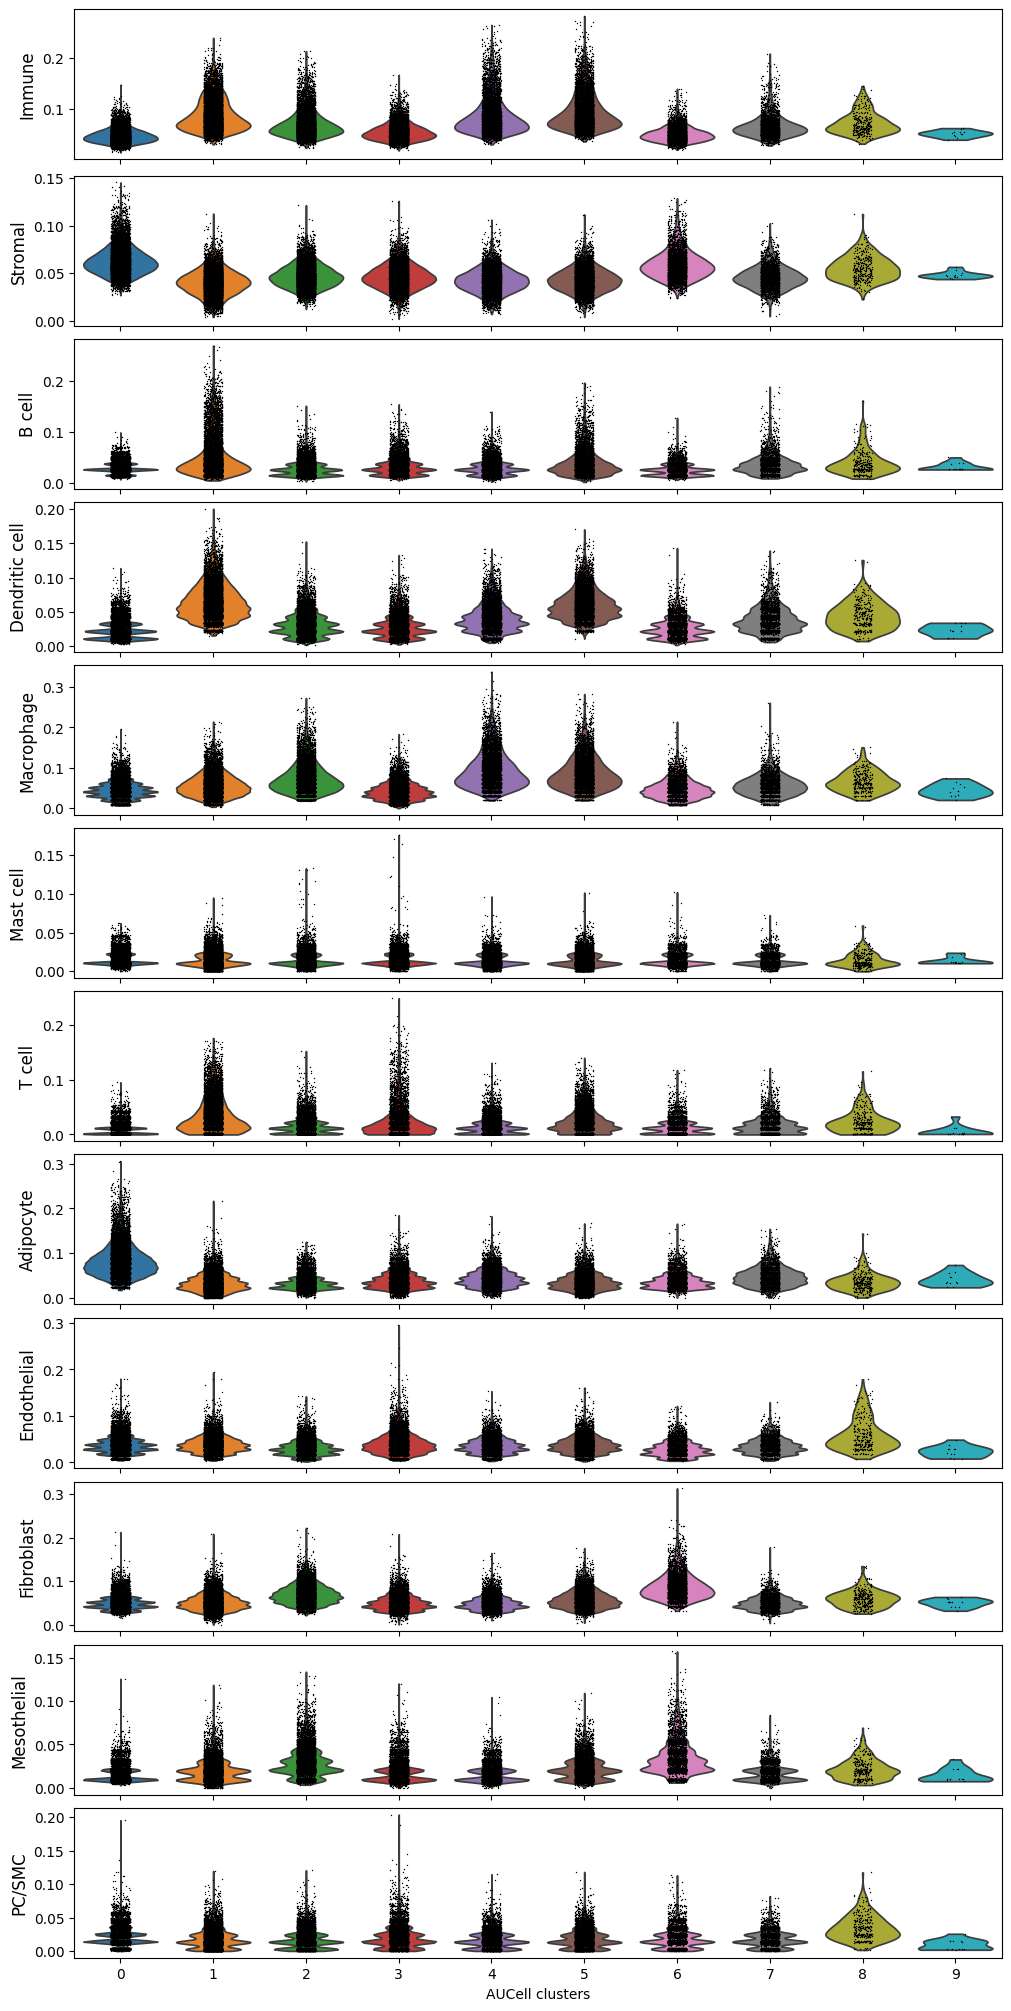

In [352]:
f = plt.figure(figsize=(10, 20), layout="constrained")
plot_violinplot(aucell, aucell.var_names, "AUCell_clusters", f, layer="original")

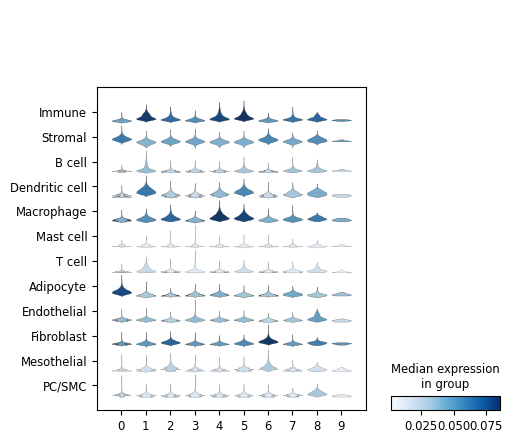

In [347]:
sc.pl.stacked_violin(
    aucell, aucell.var_names, groupby="AUCell_clusters", swap_axes=True
)

### Save/Load

In [ ]:
# SAVE
adata_FULL_WT.write(
    os.path.join(DATADIR, "processed", "combined", "raw_processed-V5 WT_filter70.h5ad")
)

In [ ]:
# LOAD
adata_FULL_WT = sc.read_h5ad(
    os.path.join(DATADIR, "processed", "combined", "raw_processed-V5 WT_filter75.h5ad")
)